<h1 style="text-align: center;">Distâncias Genéticas e Filogenia</h1>

**Alunas:**  
- Ana Luiza Poletto Loss
- Eloisa Maria Amador Souza
- Giovana Martins Coelho


**Matéria:** Espaço Normado

**Data:** 24/11/2025

# ______________________________________________________________________________________

## Problemática

A construção de árvores filogenéticas é fundamental para estudos evolutivos, sendo a escolha da métrica de distância um fator crítico que pode influenciar significativamente a topologia da árvore resultante. Este estudo compara três métricas de distância, Hamming, Euclidiana e Levenshtein, na inferência de relações filogenéticas entre sequências de DNA.

A filogenia molecular utiliza sequências de DNA para inferir relações evolutivas entre espécies. Diferentes métricas de distância podem capturar aspectos distintos da divergência genética, influenciando a topologia das árvores filogenéticas resultantes.

# _____________________________________________________________________________________

============================================================
#### Anaconda
============================================================

O Anaconda é preferido ao uso direto do Jupyter porque permite criar ambientes isolados com versões específicas de Python e bibliotecas, evitando conflitos entre dependências, algo comum em bioinformática e computação científica. Ele também instala pacotes complexos (como NumPy, SciPy e scikit-bio) de forma estável e pré-compilada, garantindo compatibilidade, reprodutibilidade e facilidade de manutenção. Além disso, quando o Jupyter é iniciado dentro de um ambiente Conda, ele utiliza exatamente as versões das bibliotecas daquele ambiente, tornando o trabalho muito mais controlado e confiável.


Para preparar o ambiente de filogenia, primeiro foi criado um ambiente Conda com `conda create -n filogenia python=3.9`, depois ative-o com `conda activate filogenia`; em seguida instale as bibliotecas principais usando `conda install scikit-bio numpy=1.26 pandas scipy matplotlib seaborn -y` e instale o pacote Levenshtein via `pip install python-Levenshtein`; por fim, abra o ambiente interativo executando `jupyter notebook`, e dentro do notebook teste as importações com `import skbio, numpy, pandas, scipy, seaborn, matplotlib.pyplot as plt, Levenshtein` para garantir que tudo está funcionando corretamente.

### IMPORTAÇÕES

Preparar o ambiente com todas as ferramentas necessárias para a análise.

In [6]:
import numpy as np                 
import seaborn as sns              
import matplotlib.pyplot as plt   
from skbio import DistanceMatrix   # Para matrizes de distância
from skbio.tree import nj          # Para algoritmo Neighbor-Joining
from Bio import SeqIO              # Para manipulação de sequências
import Levenshtein                 # Para cálculo da distância de Levenshtein

# Código com o corte das sequências

Esse código busca verificar o comportamento com as sequencias COI "cortadas" para que fiquem com o mesmo tamanho e consiga gerar as árvores.

#### Configurações do Usuário

> Aqui são definidos os parâmetros que podem ser facilmente modificados pelo usuário. O grupo externo que eu utilizei foi o zebra fish (Danio rerio) mas pode ser outro, desde que definido pelo usuário.

In [15]:
# caminho do usuário

fasta_path = r"C:\Users\ana24045\OneDrive - ILUM ESCOLA DE CIÊNCIA\Área de Trabalho\4 semestre\Espaços Normados\filo.fasta"
OUTGROUP_NAME = "Danio"

#### Leitura e Processamento do FASTA

> Para fazer o arquivo FASTA de maneira manual é preciso ir ao NCBI [1] seleciona a aba "nucleotide" e procurar pela especia + COI (ex: Pan troglodytes COI). Você clica em FASTA e copia o que estiver escrito ali. Você pode armazenas em txt e colocar todas as sequências que precisa.  Depois salve como arquivo .fasta.
>
> Esse trecho de código lê o arquivo FASTA informado usando BioPython, garantindo que ele exista e contenha sequências válidas; caso contrário, emite uma mensagem de erro e encerra o programa. Depois de carregado, ele extrai os identificadores `rec.id` e as sequências de nucleotídeos `rec.seq` para listas separadas, exibindo na tela quais táxons foram encontrados. Em seguida, o código identifica o comprimento da menor sequência presente no arquivo e realiza uma normalização cortando todas as outras sequências para esse tamanho mínimo, garantindo que fiquem alinhadas e compatíveis para cálculos de distância, finalizando com uma mensagem informando o tamanho final adotado.

In [8]:
# Leitura e Processamento do FASTA


try:
    records = list(SeqIO.parse(fasta_path, "fasta"))
    if not records:
        raise ValueError("Arquivo FASTA vazio ou incorreto.")
    print("FASTA carregado com sucesso!")
except Exception as e:
    print(f"Erro ao carregar FASTA: {e}")
    raise SystemExit()

names = [rec.id for rec in records]
seqs = [str(rec.seq) for rec in records]

print("Táxons detectados:", names)

# Normalização
min_len = min(len(s) for s in seqs)
seqs = [s[:min_len] for s in seqs]
print(f"Todas as sequências foram cortadas para o comprimento mínimo: {min_len}")

FASTA carregado com sucesso!
Táxons detectados: ['Pan', 'Gorilla', 'Canis', 'Gallus', 'Felis', 'Bos', 'Danio']
Todas as sequências foram cortadas para o comprimento mínimo: 655


#### Funções de Distância
>   Esse bloco define três funções usadas para calcular diferentes tipos de distância entre pares de sequências: Hamming, Euclidiana e Levenshtein.
> 
> A distância de Hamming compara posição por posição e conta quantos caracteres diferem entre as duas sequências alinhadas.
>
> A distância Euclidiana transforma cada nucleotídeo em um valor numérico (A=0, C=1, G=2, T=3), cria vetores correspondentes às sequências e calcula a norma Euclidiana da diferença entre eles, tratando as sequências como pontos em um espaço numérico.
>
> Já a distância de Levenshtein mede o número mínimo de operações de edição (inserção, deleção ou substituição) necessárias para transformar uma sequência na outra, permitindo comparar sequências mesmo quando têm tamanhos diferentes.

In [9]:
# definição das funções utilizadas para cálulo das distâncias

def dist_hamming(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def dist_euclidiana(s1, s2):
    map_nt = {'A':0, 'C':1, 'G':2, 'T':3}
    v1 = np.array([map_nt.get(nt, 0) for nt in s1])
    v2 = np.array([map_nt.get(nt, 0) for nt in s2])
    return np.linalg.norm(v1 - v2)

def dist_levenshtein(s1, s2):
    return Levenshtein.distance(s1, s2)

#### Matriz de Distância e Visualização

> Para fazer as matrizes de distância e visualizar as distâncias entre todos os pares de sequências.

>Nesta etapa, calculamos a matriz de distâncias entre todas as sequências usando uma função de distância escolhida (Hamming, Euclidiana ou Levenshtein). Cada elemento da matriz representa o quão diferente duas sequências são:  

>- M[i,j] = distância entre a sequência `i` e a sequência `j`  
>- A matriz é simétrica, ou seja, M[i,j] = M[j,i]  
>- Distâncias menores indicam sequências mais similares; distâncias maiores indicam maior divergência.

>Em seguida, geramos um mapa de calor *heatmap* para visualizar essas diferenças de forma intuitiva, onde as cores representam valores maiores ou menores de distância, e os nomes das sequências aparecem nos eixos para facilitar a identificação.


In [10]:
# Montando as matrizes de distância 

def compute_distance_matrix(names, seqs, metric_fn):
    n = len(seqs)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = metric_fn(seqs[i], seqs[j])
            M[i, j] = M[j, i] = d
    return M

def plot_heatmap(M, names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(M, xticklabels=names, yticklabels=names, annot=True, cmap="viridis")
    plt.title(title)
    plt.show()

#### Construção da Árvore Filogenética

> Para construir a árvore filogenética precisa de um algoritmo para isso e usamos o algoritmo Neighbor-Joining.
>
> Esse trecho de código constrói uma árvore filogenética pelo método *Neighbor-Joining* (NJ) a partir de uma matriz de distâncias entre sequências. Primeiro, ele cria um objeto `DistanceMatrix` do scikit-bio usando a matriz M e os nomes dos táxons. Em seguida, aplica a função `nj()` para gerar a árvore NJ. Como o retorno de `nj()` depende da versão do scikit-bio, o código tenta primeiro usar `tree_skbio.write(format='newick')` (versões modernas) e, caso dê erro, usa um *fallback* com `StringIO` para capturar a árvore no formato Newick em versões antigas. Por fim, o código limpa possíveis espaços extras e converte a string Newick para um objeto Tree do ETE3, que permite visualização, manipulação e enraizamento da árvore dentro do Python.

In [11]:
# Construindo a árvore

def build_nj_tree(names, M):
    dm = DistanceMatrix(M, ids=names)
    tree_skbio = nj(dm)
    
    # CORREÇÃO: Versões modernas do scikit-bio retornam string diretamente
    try:
        # Tentativa para versões mais recentes
        newick_str = tree_skbio.write(format='newick')
    except:
        # Fallback para versões antigas
        from io import StringIO
        buffer = StringIO()
        tree_skbio.write(buffer, format='newick')
        newick_str = buffer.getvalue()
    
    # Limpar o formato para o ETE3
    newick_str = newick_str.strip()
    
    return Tree(newick_str, format=1)

#### Visualização da Árvore

> Para visualizar a árvore filogenética de múltiplas formas (texto, ASCII e imagem) é feita nessa célula.
>
> Essa função `plot_tree` serve para exibir e salvar a árvore filogenética de forma clara e organizada, com suporte a renderização horizontal. Primeiro, ela imprime no notebook o título da árvore, o formato Newick completo `tree.write(format=1)` e uma representação ASCII simplificada para visualização rápida.

>Se for fornecido um caminho para salvar `png_path`, a função configura um TreeStyle do ETE3 para controlar a aparência: exibe nomes das folhas, define o modo radial (ou horizontal), ajusta margens entre ramos, e melhora a visualização dos ramos e rótulos. O estilo da raiz também é destacado com um ponto vermelho pequeno.

>Depois, o diretório do arquivo PNG é criado se não existir, e a árvore é renderizada com tamanho definido (900x600 pixels). Por fim, o arquivo é exibido inline no notebook com `display(Image(...)`, e mensagens confirmam se a imagem foi salva corretamente ou se ocorreu algum erro durante a renderização.

>Em resumo, essa função combina visualização textual e gráfica, permitindo inspecionar rapidamente a árvore e também gerar um arquivo de imagem para documentação ou publicação.

In [12]:
# Função para visualização da árvore 

def plot_tree(tree, title, png_path=None):
    print(f"\n========== ÁRVORE: {title} ==========\n")
    print(tree.write(format=1))
    print(tree.get_ascii(show_internal=False))

    if png_path:
        try:
            # Definindo que a árvore será horizontal
            
            ts = TreeStyle()
            ts.show_leaf_name = True
            ts.mode = "r"  # "r" para radial, "c" para circular - vamos usar horizontal
            ts.rotation = 0  # Sem rotação
            ts.orientation = 0  # Horizontal
            ts.branch_vertical_margin = 10  # Espaço entre ramos
            
            # Configurar para layout horizontal (esquerda para direita)
            ts.force_topology = False
            ts.complete_branch_lines_when_necessary = True
            
            # Melhorar a aparência dos nomes
            ts.show_branch_length = False
            ts.show_scale = False
            
            # Estilo na raiz
            if tree.get_tree_root():
                nstyle = NodeStyle()
                nstyle["size"] = 0  # Tamanho pequeno para não atrapalhar
                nstyle["fgcolor"] = "red"
                tree.get_tree_root().set_style(nstyle)

            os.makedirs(os.path.dirname(png_path) or ".", exist_ok=True)
            
            # Renderizar em modo horizontal
            tree.render(png_path, w=900, h=600, units="px", tree_style=ts)
            
            if os.path.exists(png_path):
                display(Image(png_path))
                print(f"✅ Imagem salva em: {png_path}")
            else:
                print(f"❌ Arquivo não foi criado: {png_path}")

        except Exception as e:
            print(f"❌ Erro ao renderizar PNG: {e}")

#### Execução Principal

>Esse bloco representa a execução principal do *pipeline* filogenético. Primeiro, ele define um dicionário `metrics` com as três funções de distância disponíveis: Hamming, Euclidiana e Levenshtein. Em seguida, para cada métrica, o código:

> 1 - Imprime mensagens informando qual métrica está sendo processada.

> 2 - Calcula a matriz de distâncias entre todas as sequências usando `compute_distance_matrix`.

> 3 - Gera um *heatmap* para visualizar essas distâncias de forma mais intuitiva.

> 4 - Constrói uma árvore NJ *`Neighbor-Joining`* a partir da matriz de distâncias com `build_nj_tree`.

> 5- Tenta aplicar o outgroup verificando se o táxon definido em `OUTGROUP_NAME` está presente entre as folhas da árvore; se encontrado, usa `tree.set_outgroup(leaf)` para enraizar a árvore, e define título e caminho do arquivo PNG correspondente. Caso não seja encontrado, a árvore é mantida não enraizada e uma mensagem de aviso é exibida.

> 6 - Por fim, chama `plot_tree` para exibir a árvore no notebook e salvar a imagem, com todos os ajustes de estilo definidos previamente.

> Após iterar por todas as métricas, imprime uma mensagem final indicando que o processamento filogenético foi concluído, garantindo que o pipeline gere tanto visualizações das distâncias quanto árvores enraizadas ou não, de maneira automática e didática.


Processando Hamming...



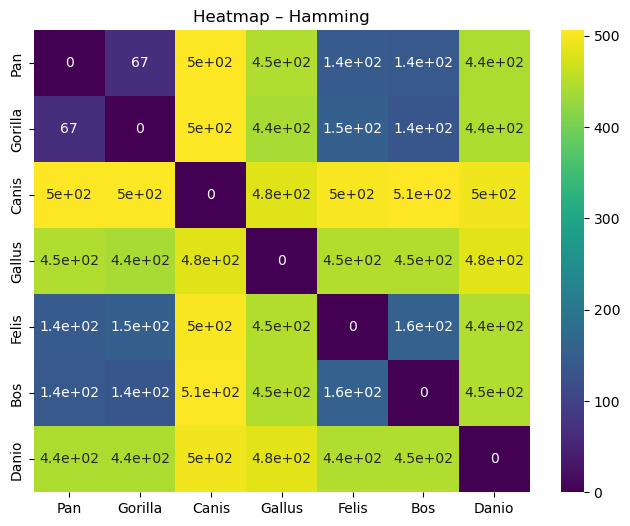

✔ Outgroup 'Danio' aplicado com sucesso.

========== ÁRVORE: Árvore NJ – Hamming (Enraizada) ==========

(Danio:114.75,((Canis:265.8,Gallus:216.2):18.5,(((Pan:33.4167,Gorilla:33.5833):32.6875,Bos:71.3125):6.9375,Felis:75.5625):139.688):114.75);

   /-Danio
  |
  |      /-Canis
--|   /-|
  |  |   \-Gallus
  |  |
   \-|         /-Pan
     |      /-|
     |   /-|   \-Gorilla
     |  |  |
      \-|   \-Bos
        |
         \-Felis


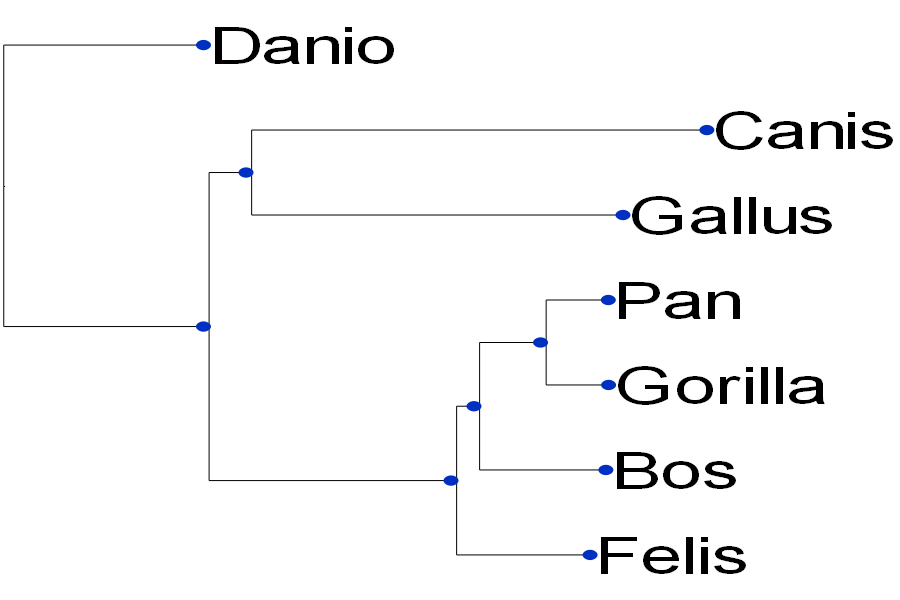

✅ Imagem salva em: NJ_Rooted_Hamming.png

Processando Euclidiana...



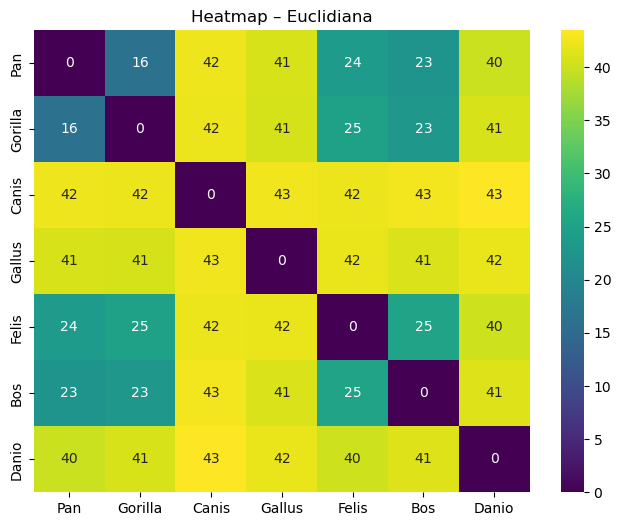

✔ Outgroup 'Danio' aplicado com sucesso.

========== ÁRVORE: Árvore NJ – Euclidiana (Enraizada) ==========

(Danio:10.3723,((Canis:21.8975,Gallus:20.6466):0.696879,(((Pan:7.91125,Gorilla:8.52043):2.80643,Bos:11.823):0.981849,Felis:12.3264):7.45141):10.3723);

   /-Danio
  |
  |      /-Canis
--|   /-|
  |  |   \-Gallus
  |  |
   \-|         /-Pan
     |      /-|
     |   /-|   \-Gorilla
     |  |  |
      \-|   \-Bos
        |
         \-Felis


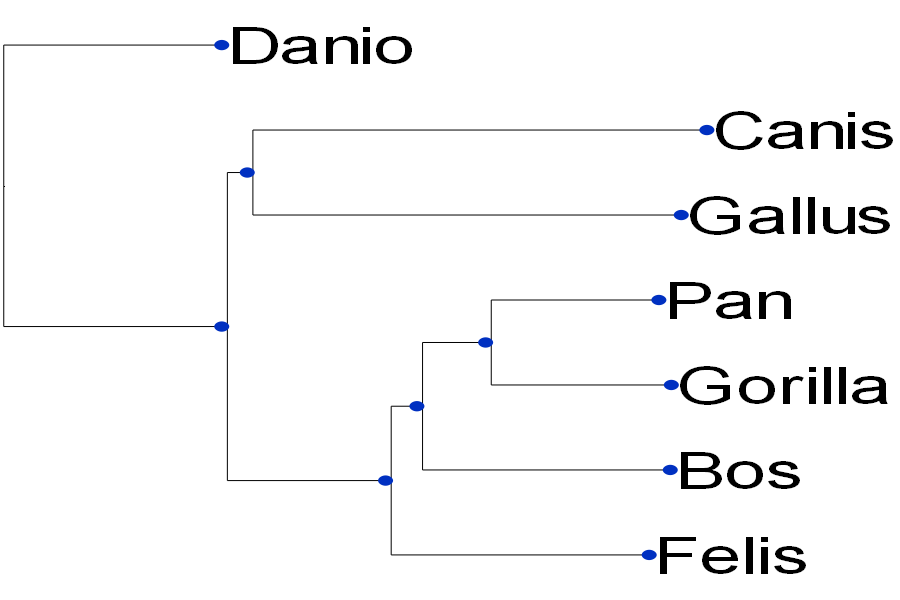

✅ Imagem salva em: NJ_Rooted_Euclidiana.png

Processando Levenshtein...



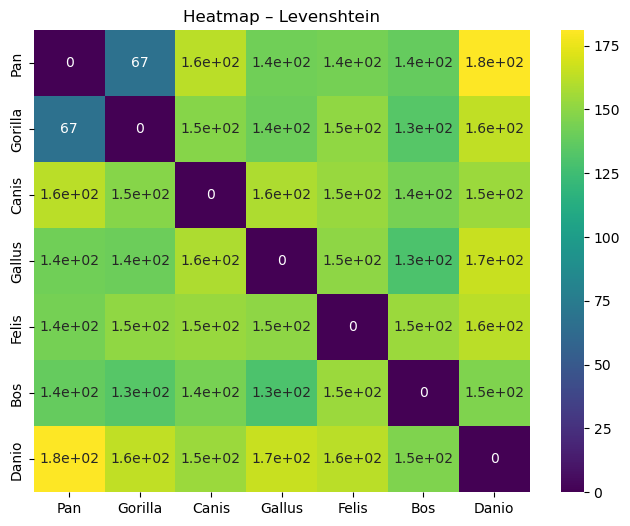

✔ Outgroup 'Danio' aplicado com sucesso.

========== ÁRVORE: Árvore NJ – Levenshtein (Enraizada) ==========

(Danio:40.7188,(Canis:72.5625,(Felis:75.375,((Pan:36.5,Gorilla:30.5):36.875,(Gallus:68.0625,Bos:61.9375):2.875):6.25):5.125):40.7188);

   /-Danio
  |
--|   /-Canis
  |  |
   \-|   /-Felis
     |  |
      \-|      /-Pan
        |   /-|
        |  |   \-Gorilla
         \-|
           |   /-Gallus
            \-|
               \-Bos


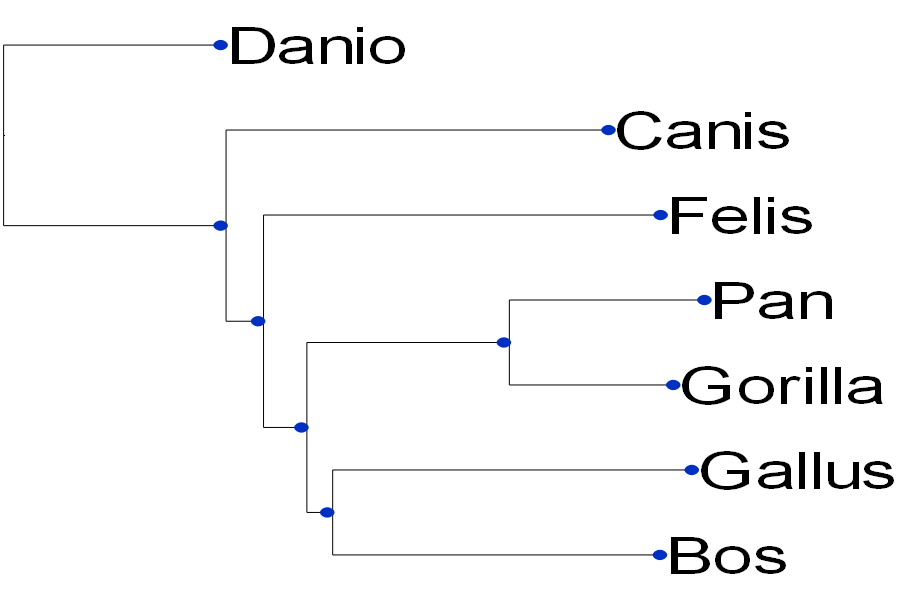

✅ Imagem salva em: NJ_Rooted_Levenshtein.png

Processamento finalizado!


In [13]:
# Execução 

metrics = {
    "Hamming": dist_hamming,
    "Euclidiana": dist_euclidiana,
    "Levenshtein": dist_levenshtein
}

for metric_name, fn in metrics.items():
    print("\n=======================================================")
    print(f"Processando {metric_name}...")
    print("=======================================================\n")

    M = compute_distance_matrix(names, seqs, fn)
    plot_heatmap(M, names, f"Heatmap – {metric_name}")

    tree = build_nj_tree(names, M)

    # Enraizamento, permite uma verificação mais robusta
    outgroup_found = False
    for leaf in tree:
        if leaf.name == OUTGROUP_NAME:
            outgroup_found = True
            try:
                tree.set_outgroup(leaf)
                print(f"✔ Outgroup '{OUTGROUP_NAME}' aplicado com sucesso.")
                title = f"Árvore NJ – {metric_name} (Enraizada)"
                png = f"NJ_Rooted_{metric_name}.png"
                break
            except Exception as e:
                print(f"⚠️ Erro ao definir outgroup: {e}")
                title = f"Árvore NJ – {metric_name}"
                png = f"NJ_{metric_name}.png"
                break
    
    if not outgroup_found:
        print(f"⚠️ Outgroup '{OUTGROUP_NAME}' não encontrado na árvore.")
        title = f"Árvore NJ – {metric_name}"
        png = f"NJ_{metric_name}.png"

    plot_tree(tree, title, png)

print("\nProcessamento finalizado!")

# Sem corte de sequências

Esse código busca verificar o comportamento com as sequencias COI sem corte e mostre que não é possivel funcionar com essas métricas.

FASTA carregado com sucesso!
Táxons detectados: ['Pan', 'Gorilla', 'Canis', 'Gallus', 'Felis', 'Bos', 'Danio']
Tamanhos das sequências: [658, 658, 675, 657, 658, 658, 655]

Processando Hamming...

⚠️ Hamming: Pan × Canis → ❌ Hamming requer sequências de mesmo tamanho.
❌ Hamming não pôde ser calculada por incompatibilidade de tamanhos.


Processando Euclidiana...

⚠️ Euclidiana: Pan × Canis → ❌ Distância Euclidiana requer sequências de mesmo tamanho.
❌ Euclidiana não pôde ser calculada por incompatibilidade de tamanhos.


Processando Levenshtein...



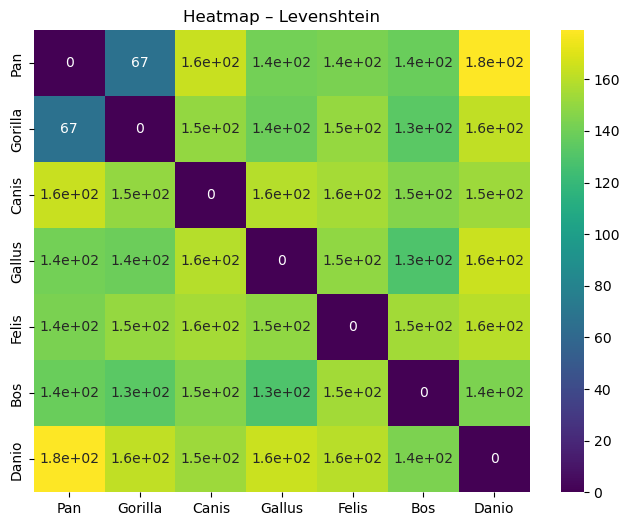

✔ Outgroup 'Danio' aplicado.

========== ÁRVORE: Árvore NJ – Levenshtein (Enraizada) ==========

(Danio:39.6562,(Canis:73.6875,(Felis:75.2917,((Pan:36.5,Gorilla:30.5):36.8125,(Gallus:67.125,Bos:61.875):2.9375):6.3125):5.70833):39.6562);

   /-Danio
  |
--|   /-Canis
  |  |
   \-|   /-Felis
     |  |
      \-|      /-Pan
        |   /-|
        |  |   \-Gorilla
         \-|
           |   /-Gallus
            \-|
               \-Bos


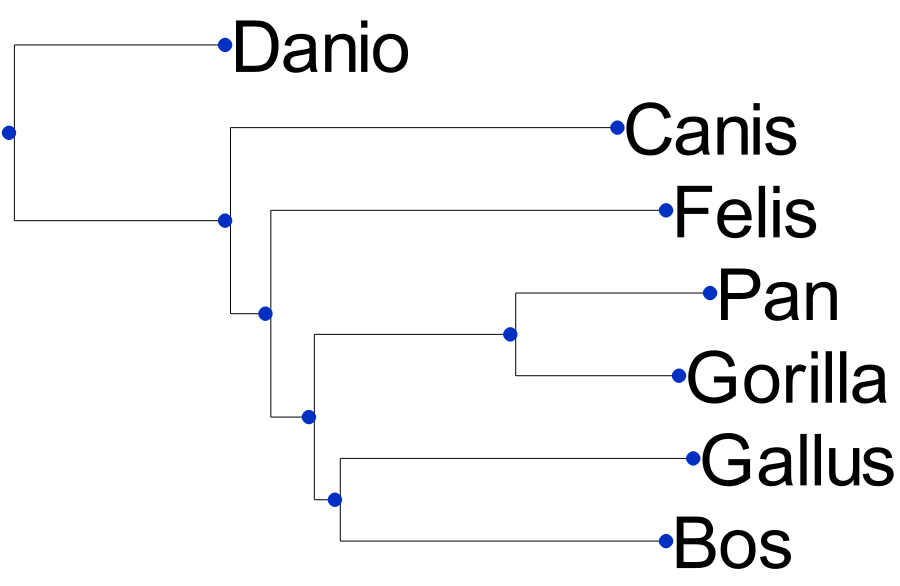


Processamento finalizado!


In [17]:
# Caminho do usuário

fasta_path = r"C:\Users\ana24045\OneDrive - ILUM ESCOLA DE CIÊNCIA\Área de Trabalho\4 semestre\Espaços Normados\filo.fasta"
OUTGROUP_NAME = "Danio"


# Leitura do FASTA


try:
    records = list(SeqIO.parse(fasta_path, "fasta"))
    if not records:
        raise ValueError("Arquivo FASTA vazio ou incorreto.")
    print("FASTA carregado com sucesso!")
except Exception as e:
    print(f"❌ Erro ao carregar FASTA: {e}")
    raise SystemExit()

names = [rec.id for rec in records]
seqs = [str(rec.seq) for rec in records]

print("Táxons detectados:", names)

# # Normalização  ### Essa parte é omitida para mostrar como não funciona as métricas de Hamming e Euclidiana.
# min_len = min(len(s) for s in seqs)
# seqs = [s[:min_len] for s in seqs]
# print(f"Todas as sequências foram cortadas para o comprimento mínimo: {min_len}")



# Verificação dos tamanhos das sequências

seq_lengths = [len(s) for s in seqs]
print("Tamanhos das sequências:", seq_lengths)



# Funções de distância com verificação de compatibilidade

def dist_hamming(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("❌ Hamming requer sequências de mesmo tamanho.")
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def dist_euclidiana(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("❌ Distância Euclidiana requer sequências de mesmo tamanho.")
    map_nt = {'A':0, 'C':1, 'G':2, 'T':3}
    v1 = np.array([map_nt.get(nt, 0) for nt in s1])
    v2 = np.array([map_nt.get(nt, 0) for nt in s2])
    return np.linalg.norm(v1 - v2)

def dist_levenshtein(s1, s2):
    return Levenshtein.distance(s1, s2)



# Matriz de distância

def compute_distance_matrix(names, seqs, metric_fn, metric_name):
    n = len(seqs)
    M = np.full((n, n), np.nan)

    for i in range(n):
        for j in range(i+1, n):
            try:
                d = metric_fn(seqs[i], seqs[j])
                M[i, j] = M[j, i] = d
            except Exception as e:
                print(f"⚠️ {metric_name}: {names[i]} × {names[j]} → {e}")
                return None  # incompatível, cancela matriz

    return np.nan_to_num(M)

def plot_heatmap(M, names, title):
    if M is None:
        print(f"❌ Heatmap não gerado para {title} (dados incompatíveis).")
        return

    plt.figure(figsize=(8, 6))
    sns.heatmap(M, xticklabels=names, yticklabels=names, annot=True, cmap="viridis")
    plt.title(title)
    plt.show()


    
# Construção da Árvore

def build_nj_tree(names, M):
    dm = DistanceMatrix(M, ids=names)
    tree_skbio = nj(dm)

    buffer = StringIO()
    tree_skbio.write(buffer, format='newick')
    newick_str = buffer.getvalue().strip()

    return Tree(newick_str, format=1)



# Plot da Árvore

def plot_tree(tree, title, png_path=None):
    print(f"\n========== ÁRVORE: {title} ==========\n")
    print(tree.write(format=1))
    print(tree.get_ascii(show_internal=False))

    if png_path:
        try:
            ts = TreeStyle()
            ts.show_leaf_name = True
            ts.mode = "r"   # radial está estável
            ts.show_branch_length = False
            ts.show_scale = False

            os.makedirs(os.path.dirname(png_path) or ".", exist_ok=True)
            tree.render(png_path, w=900, units="px", tree_style=ts)

            display(Image(png_path))
        except Exception as e:
            print(f"❌ Erro ao renderizar PNG: {e}")


            
# Execução Principal

metrics = {
    "Hamming": dist_hamming,
    "Euclidiana": dist_euclidiana,
    "Levenshtein": dist_levenshtein
}

for metric_name, fn in metrics.items():
    print("\n=======================================================")
    print(f"Processando {metric_name}...")
    print("=======================================================\n")

    M = compute_distance_matrix(names, seqs, fn, metric_name)

    if M is None:
        print(f"❌ {metric_name} não pôde ser calculada por incompatibilidade de tamanhos.\n")
        continue

    plot_heatmap(M, names, f"Heatmap – {metric_name}")

    tree = build_nj_tree(names, M)

    # Enraizamento
    leaves = {leaf.name: leaf for leaf in tree}

    if OUTGROUP_NAME in leaves:
        try:
            tree.set_outgroup(leaves[OUTGROUP_NAME])
            print(f"✔ Outgroup '{OUTGROUP_NAME}' aplicado.")
            title = f"Árvore NJ – {metric_name} (Enraizada)"
            png = f"NJ_Rooted_{metric_name}.png"
        except:
            print("⚠️ Falha ao enraizar.")
            title = f"Árvore NJ – {metric_name}"
            png = f"NJ_{metric_name}.png"
    else:
        print(f"⚠️ Outgroup '{OUTGROUP_NAME}' não encontrado.")
        title = f"Árvore NJ – {metric_name}"
        png = f"NJ_{metric_name}.png"

    plot_tree(tree, title, png)

print("\nProcessamento finalizado!")


# Referências

[1] National Center for Biotechnology Information. Disponível em: https://www.ncbi.nlm.nih.gov/nuccore. Acesso em: 15 nov. 2025.

[2]. CHAPMAN, Brad; CHANG, Jeff. Biopython Tutorial and Cookbook. Disponível em: http://biopython.org. Acesso em: 15 nov. 2025.

[3]. GUSFIELD, Dan. Algorithms on Strings, Trees, and Sequences: Computer Science and Computational Biology. Cambridge: Cambridge University Press, 1997.

[4]. FELSENSTEIN, Joseph. Inferring Phylogenies. Sunderland: Sinauer Associates, 2004.

Por fim, o desenvolvimento do código também contou com auxílio de IA